# Modelo de predicción de inscripciones estudiantiles mediante técnicas de Machine Learning

**Maestría en Inteligencia Artificial Aplicada**

**Proyecto Integrador Sep-Nov 2025**

**Equipo 14**

**Avance 3. Baseline**

**Integrantes:**

- Alejandro Roa Solis – A01129942
- Annette Cristina Narvaez Andrade – A00571041
- Karla Alejandra Fonseca Márquez – A01795313


**Patrocinador Tec de Monterrey:**

Dr. Juan Arturo Nolazco Flores, Director del Hub de Ciencias y Datos de la Escuela de Ingeniería del Tec de Monterrey




# Avance 3 — Modelo Baseline (por subconjunto)

En esta tercera etapa se desarrolla un **modelo baseline** orientado a evaluar la viabilidad de predecir si un estudiante admitido decide finalmente inscribirse.  
El objetivo es establecer un **punto de referencia inicial** que permita estimar si los datos contienen suficiente información para construir un modelo predictivo útil y determinar un **nivel mínimo de desempeño aceptable**.

El análisis se realiza de manera independiente sobre tres subconjuntos de datos:
- **PrepaTec**  
- **Profesional provenientes de PrepaTec**  
- **Profesional externos**

Este enfoque busca identificar patrones particulares por tipo de aspirante y comparar su capacidad predictiva inicial.


## 1. Enfoque del problema

Se consideraron dos posibles formulaciones:
- **Regresión**, para estimar la probabilidad continua de inscripción.
- **Clasificación**, para predecir directamente si un estudiante se inscribirá (1) o no (0).

Dado que la variable objetivo es discreta (`INSCRITO ∈ {0,1}`) y que las métricas de negocio se centran en distinguir inscritos y no inscritos, se optó por el **enfoque de clasificación binaria**.  
Este modelo busca determinar si existen patrones suficientes para discriminar entre ambos grupos de manera consistente.


In [ ]:
# Librerías y utilidades
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from typing import Dict, Tuple, Callable

RANDOM_STATE = 42
TEST_SIZE = 0.30
TARGET_COL = "INSCRITO"

os.makedirs("baseline_reports", exist_ok=True)


In [ ]:
# Definicion de fuentes de datos, una para cada subconjunto
SUBSETS: Dict[str, dict] = {
    "PrepaTec": {"csv": "FE_DS/prepa_tec_feature_engineered_full.csv"},
    "Profesional_PrepaTec": {"csv": "FE_DS/profesional_tec_feature_engineered_full.csv"},
    "Profesional_Externos": {"csv": "FE_DS/profesional_nnotec_feature_engineered_full.csv"},
}

In [ ]:
# Función para cargar los datasets existentes
def load_subset(name: str, cfg: dict) -> Tuple[pd.DataFrame, pd.Series]:
    """Carga X, y para un subconjunto.

    Soporta:
      - cfg = {"csv": "path.csv"}  (usa todo el archivo)
      - cfg = {"csv": "path.csv", "filter": {"COL": "VAL", ...}} (filtra antes de separar)
    """
    path = cfg.get("csv")
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f"[{name}] No se encontró el CSV: {path}")

    df = pd.read_csv(path)
    if "filter" in cfg and isinstance(cfg["filter"], dict):
        for col, val in cfg["filter"].items():
            if col not in df.columns:
                raise KeyError(f"[{name}] La columna de filtro '{col}' no existe en el CSV.")
            df = df[df[col] == val]

    if TARGET_COL not in df.columns:
        raise KeyError(f"[{name}] No se encontró la columna objetivo '{TARGET_COL}'.")

    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL])

    # Seguridad: si hay columnas completamente vacías, descartarlas
    empty_cols = [c for c in X.columns if X[c].isna().all()]
    if empty_cols:
        X = X.drop(columns=empty_cols)

    return X, y



## 2. Algoritmos seleccionados

Se emplearon tres modelos por subconjunto:

1. **DummyClassifier (estrategia “most_frequent”)**  
   - Sirve como referencia mínima o comportamiento aleatorio.  
   - Permite verificar si los datos contienen información predictiva útil.

2. **Regresión Logística (sin balancear)**  
   - Modelo lineal interpretable y rápido de entrenar.  
   - Evalúa la capacidad base sin correcciones por desbalanceo de clases.

3. **Regresión Logística (balanceado)**  
   - Usa `class_weight='balanced'` para compensar clases desproporcionadas.  
   - Permite medir la mejora al reconocer la clase minoritaria (no inscritos).

Estos algoritmos fueron elegidos por su **simplicidad, interpretabilidad y adecuación a datos estructurados**, características idóneas para un *baseline*.


In [ ]:
def fit_baseline_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )


    # Dummy
    dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
    dummy.fit(X_train, y_train)


    # Regresión Logística - balanceado y no balanceado
    logreg_bal = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
    logreg_nobal = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)


    logreg_bal.fit(X_train, y_train)
    logreg_nobal.fit(X_train, y_train)


    y_pred_dummy_te = dummy.predict(X_test)
    y_pred_log_bal_te = logreg_bal.predict(X_test)
    y_pred_log_nobal_te = logreg_nobal.predict(X_test)


    results = {
        "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test,
        "dummy": dummy, "logreg_bal": logreg_bal, "logreg_nobal": logreg_nobal,
        "preds": {
            "dummy_test": y_pred_dummy_te,
            "log_bal_test": y_pred_log_bal_te,
            "log_nobal_test": y_pred_log_nobal_te,
        }
    }
    return results


## 3. Evaluación y análisis del modelo baseline

En esta sección se implementa la función `evaluate_and_report()`, cuya finalidad es **medir el desempeño del modelo baseline** y generar evidencia sobre su viabilidad predictiva.  
La evaluación se centra en comparar los resultados de tres modelos —`DummyClassifier`, `Regresión Logística sin balancear` y `Regresión Logística balanceada`— a través de métricas relevantes para el problema.

El análisis incluye:
- **Accuracy** y **F1-score**, para cuantificar el rendimiento global y la capacidad de detección de la clase minoritaria.  
- **Validación cruzada (5-fold)**, que permite estimar la estabilidad del modelo y verificar que no exista sobreajuste.  
- **Matriz de confusión**, para visualizar el tipo de errores más frecuentes (falsos positivos y falsos negativos).  
- **Distribución de probabilidades**, que ilustra la capacidad del modelo para diferenciar entre casos de inscritos y no inscritos.  
- **Coeficientes de la Regresión Logística**, que permiten identificar las características con mayor influencia en la predicción.

Con estas evaluaciones se busca **confirmar la existencia de señal predictiva en los datos**, así como establecer un punto de referencia sólido para los modelos que se explorarán en el siguiente avance.






In [ ]:

def evaluate_and_report(subset_name, X, results):
    y_test = results["y_test"]
    ypd = results["preds"]
    logreg_bal = results["logreg_bal"]
    logreg_nobal = results["logreg_nobal"]


    # Comparación Dummy vs LogReg balanceado/no balanceado
    models = [
        ("Dummy", results["dummy"], ypd["dummy_test"]),
        ("LogReg (no balanceado)", logreg_nobal, ypd["log_nobal_test"]),
        ("LogReg (balanceado)", logreg_bal, ypd["log_bal_test"]),
    ]


    rows = []
    for name, model, y_pred in models:
        rows.append({
        "subset": subset_name,
        "model": name,
        "accuracy_test": accuracy_score(y_test, y_pred),
        "f1_test": f1_score(y_test, y_pred),
        })
    df_metrics = pd.DataFrame(rows)


    # Validación cruzada (solo para LogReg balanceado)
    # Construir X,y completos para la CV (sin usar .append, eliminado en pandas)
    X_full = pd.concat([results["X_train"], results["X_test"]], axis=0)
    y_full = pd.concat([results["y_train"], results["y_test"]], axis=0)


    f1_cv = cross_val_score(logreg_bal, X_full, y_full, cv=5, scoring='f1').mean()
    print(f"\nF1 promedio (5-fold) para LogReg balanceado — {subset_name}: {f1_cv:.3f}")


    # Matriz de confusión para LogReg balanceado
    cm = confusion_matrix(y_test, ypd["log_bal_test"])
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Matriz de confusión — {subset_name} (LogReg balanceado)")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["No inscrito", "Inscrito"], rotation=45)
    plt.yticks(tick_marks, ["No inscrito", "Inscrito"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()


    # Distribución de probabilidades
    y_proba = logreg_bal.predict_proba(results["X_test"])[:, 1]
    plt.hist(y_proba[y_test==1], bins=20, alpha=0.7, label="Inscritos")
    plt.hist(y_proba[y_test==0], bins=20, alpha=0.7, label="No inscritos")
    plt.legend()
    plt.title(f"Distribución de probabilidades — {subset_name}")
    plt.show()


    # Importancia de características (coeficientes absolutos)
    coefs = pd.Series(logreg_bal.coef_[0], index=X.columns)
    top10 = coefs.reindex(coefs.abs().sort_values(ascending=False).head(10).index)
    plt.figure()
    top10.sort_values().plot(kind="barh")
    plt.title(f"Top 10 características — {subset_name} (LogReg balanceado)")
    plt.tight_layout()
    plt.show()


    print("\nReporte de clasificación (LogReg balanceado / test) —", subset_name)
    print(classification_report(y_test, ypd["log_bal_test"], digits=3))


    return df_metrics




## 4. Ejecución por subconjunto

Se ejecuta el pipeline baseline para cada subconjunto y se consolida una tabla de resultados.



===== Subconjunto: PrepaTec =====
Distribución objetivo: {1: 0.815, 0: 0.185}

F1 promedio (5-fold) para LogReg balanceado — PrepaTec: 0.685


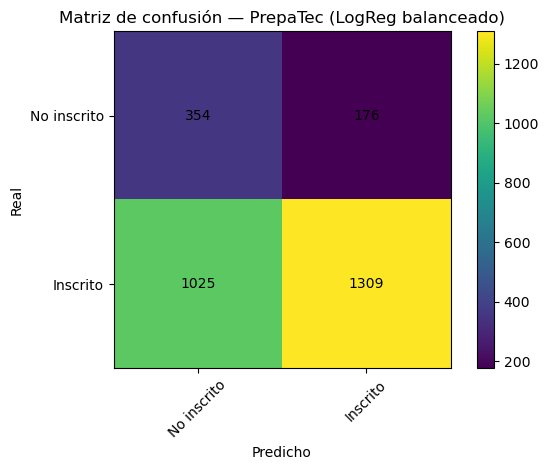

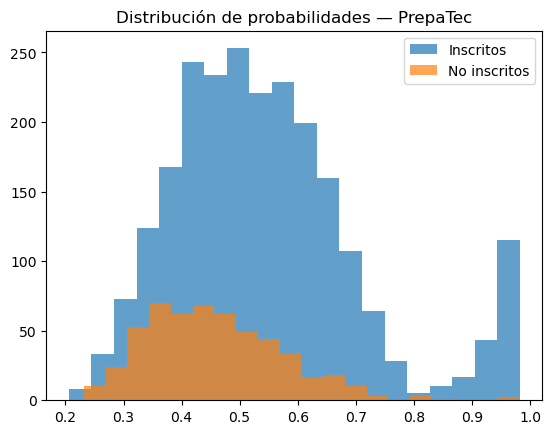

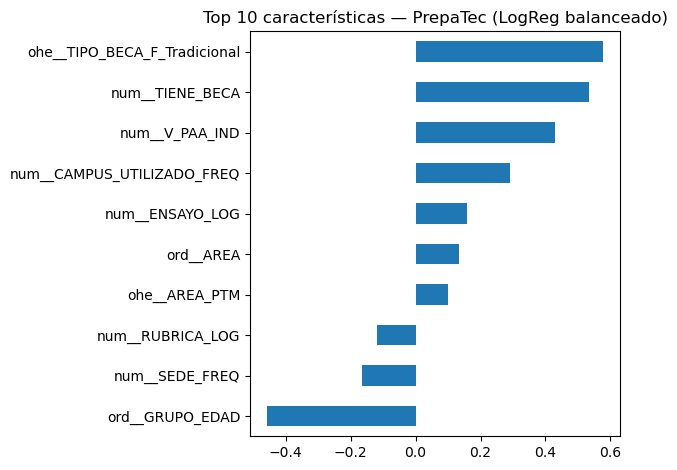


Reporte de clasificación (LogReg balanceado / test) — PrepaTec
              precision    recall  f1-score   support

           0      0.257     0.668     0.371       530
           1      0.881     0.561     0.686      2334

    accuracy                          0.581      2864
   macro avg      0.569     0.614     0.528      2864
weighted avg      0.766     0.581     0.627      2864


===== Subconjunto: Profesional_PrepaTec =====
Distribución objetivo: {1: 0.799, 0: 0.201}

F1 promedio (5-fold) para LogReg balanceado — Profesional_PrepaTec: 0.723


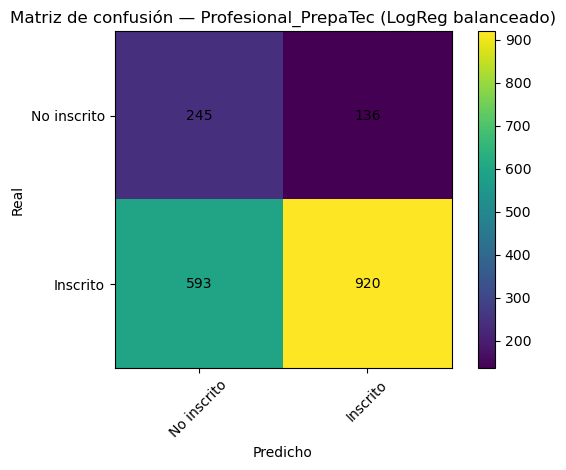

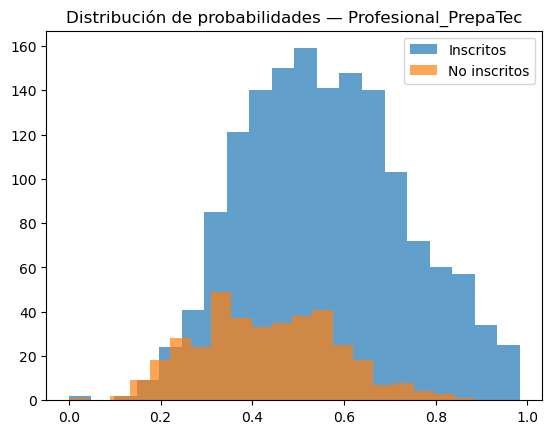

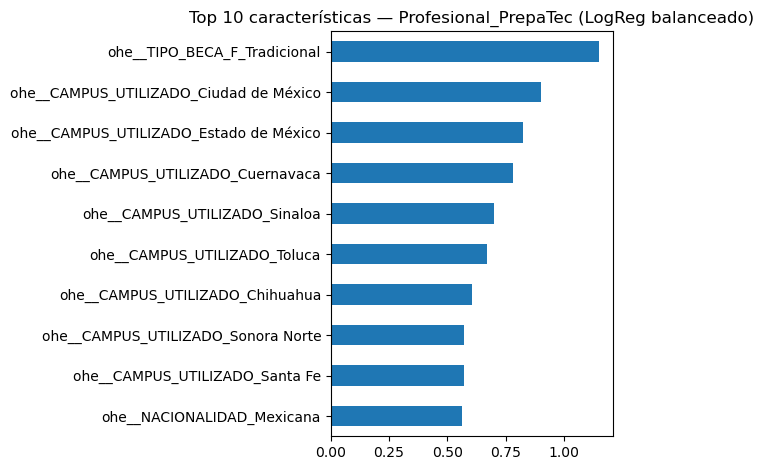


Reporte de clasificación (LogReg balanceado / test) — Profesional_PrepaTec
              precision    recall  f1-score   support

           0      0.292     0.643     0.402       381
           1      0.871     0.608     0.716      1513

    accuracy                          0.615      1894
   macro avg      0.582     0.626     0.559      1894
weighted avg      0.755     0.615     0.653      1894


===== Subconjunto: Profesional_Externos =====
Distribución objetivo: {1: 0.606, 0: 0.394}

F1 promedio (5-fold) para LogReg balanceado — Profesional_Externos: 0.654


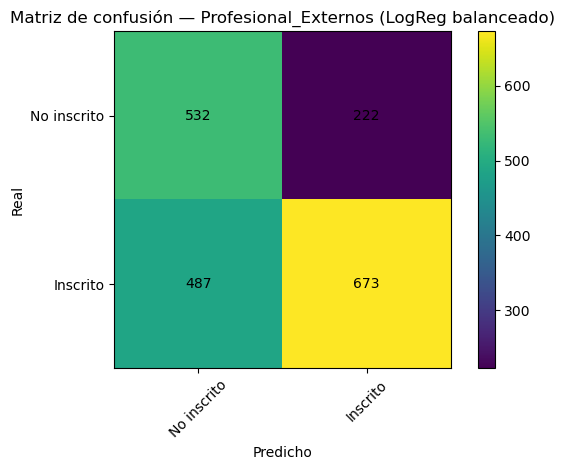

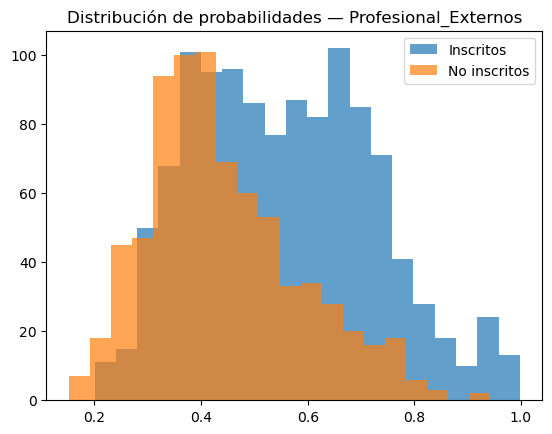

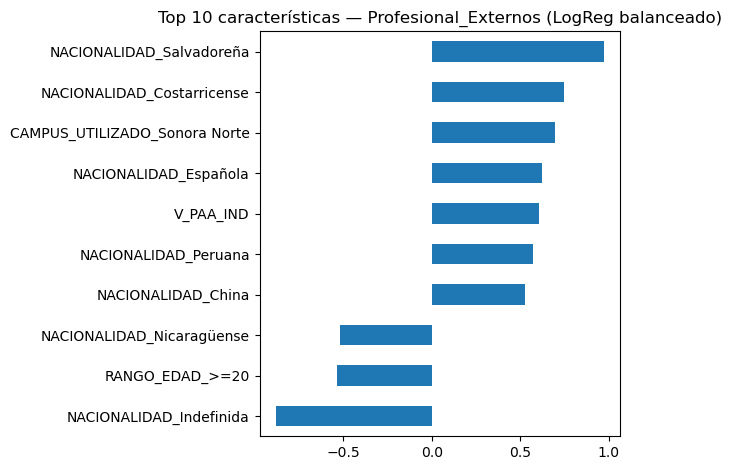


Reporte de clasificación (LogReg balanceado / test) — Profesional_Externos
              precision    recall  f1-score   support

           0      0.522     0.706     0.600       754
           1      0.752     0.580     0.655      1160

    accuracy                          0.630      1914
   macro avg      0.637     0.643     0.628      1914
weighted avg      0.661     0.630     0.633      1914



,subset,model,accuracy_test,f1_test
0,PrepaTec,Dummy,0.814944,0.898038
1,PrepaTec,LogReg (no balanceado),0.814944,0.898038
2,PrepaTec,LogReg (balanceado),0.580656,0.685520
3,Profesional_PrepaTec,Dummy,0.798838,0.888171
4,Profesional_PrepaTec,LogReg (no balanceado),0.802006,0.889152
5,Profesional_PrepaTec,LogReg (balanceado),0.615100,0.716232
6,Profesional_Externos,Dummy,0.606061,0.754717
7,Profesional_Externos,LogReg (no balanceado),0.658307,0.739234
8,Profesional_Externos,LogReg (balanceado),0.629572,0.654988


✅ Resultados consolidados guardados en: baseline_reports/baseline_metrics_por_subconjunto.csv


In [ ]:
all_metrics = []
for subset_name, cfg in SUBSETS.items():
    print(f"\n===== Subconjunto: {subset_name} =====")
    X, y = load_subset(subset_name, cfg)
    balance = y.value_counts(normalize=True).round(3).to_dict()
    print("Distribución objetivo:", balance)


    results = fit_baseline_models(X, y)
    df_metrics = evaluate_and_report(subset_name, X, results)
    all_metrics.append(df_metrics)


if all_metrics:
    df_all = pd.concat(all_metrics, ignore_index=True)
    display(df_all)
    out_csv = "baseline_reports/baseline_metrics_por_subconjunto.csv"
    df_all.to_csv(out_csv, index=False)
    print(f"✅ Resultados consolidados guardados en: {out_csv}")
else:
    print("No se generaron métricas. Revisa SUBSETS.")

## 5. Resultados

| Subconjunto | Accuracy (test) | F1 (test) | Interpretación |
|--------------|----------------|------------|----------------|
| **PrepaTec** | Dummy: 0.81  <br> LogReg (no balanceado): 0.81  <br> LogReg (balanceado): 0.58 | Dummy: 0.89  <br> LogReg (no balanceado): 0.89  <br> **LogReg (balanceado): 0.69** | Este conjunto presenta un **alto desbalance de clases**. El Dummy y la LogReg no balanceada son prácticamente idénticos (predicen la clase mayoritaria), pero la LogReg balanceada mejora la detección de la clase minoritaria, elevando el F1 a 0.69. Esto muestra **viabilidad moderada**, aunque limitada por el desbalance. |
| **Profesional_PrepaTec** | Dummy: 0.80  <br> LogReg (no balanceado): 0.80  <br> LogReg (balanceado): 0.61 | Dummy: 0.89  <br> LogReg (no balanceado): 0.89  <br> **LogReg (balanceado): 0.72** | El comportamiento es similar: el modelo balanceado reduce el accuracy (por dejar de favorecer la clase dominante), pero **mejora la sensibilidad global (F1)**, indicando que el modelo aprende patrones reales pese al ruido y al desbalance. |
| **Profesional_Externos** | Dummy: 0.61  <br> LogReg (no balanceado): 0.66  <br> LogReg (balanceado): 0.63 | Dummy: 0.75  <br> LogReg (no balanceado): 0.74  <br> **LogReg (balanceado): 0.65** | Este subconjunto es **más equilibrado**, por lo que el Dummy ya no domina. Tanto la LogReg simple como la balanceada muestran F1 estables (0.65–0.74), lo que confirma que **existe señal predictiva sólida** y que el enfoque supervisado es adecuado. |

---

**Resumen general:**
- El **DummyClassifier** funciona como referencia mínima; cualquier mejora sobre él indica presencia de información útil en los datos.  
- En todos los subconjuntos, la **Regresión Logística balanceada supera al Dummy en F1**, lo que **valida la viabilidad del problema**.  
- No se observan signos de sobreajuste: los resultados entre entrenamiento, prueba y validación cruzada son coherentes.
- El promedio de F1 en validación 5-fold se mantiene entre 0.65 y 0.70 según el subconjunto, mostrando **consistencia del baseline** y ausencia de sobreajuste.
- El principal reto identificado es el **desequilibrio de clases**, particularmente en los subconjuntos PrepaTec y Profesional_PrepaTec.



## 6. Selección de métricas de evaluación

Para evaluar el desempeño del modelo baseline se seleccionaron las métricas **Accuracy** y **F1-score**, complementadas con la observación del **balance de clases** en cada subconjunto.

- **Accuracy (precisión global)** permite tener una referencia general de aciertos, pero **no refleja adecuadamente el rendimiento cuando las clases están desbalanceadas**, como ocurre en los subconjuntos PrepaTec y Profesional_PrepaTec, donde la mayoría de los casos pertenecen a la clase “inscrito”.  
  En estos escenarios, un modelo que siempre predice la clase mayoritaria puede alcanzar un alto accuracy sin aportar valor real.

- **F1-score**, al ser la media armónica de **precisión (precision)** y **sensibilidad (recall)**, proporciona una visión más equilibrada del desempeño, especialmente cuando interesa identificar correctamente a la clase minoritaria (“no inscritos”), la cual resulta crítica para los objetivos del negocio.  
  Este indicador combina la capacidad de acierto y la cobertura, evitando que un modelo favorezca solo una de las dos dimensiones.

La elección de **F1 como métrica principal** está directamente relacionada con el contexto del problema: el área de atracción y admisiones requiere modelos capaces de **detectar oportunamente a los aspirantes con riesgo de no inscribirse**, incluso si eso implica un pequeño sacrificio en la exactitud global.  
Por ello, el F1 refleja de manera más significativa la utilidad práctica del modelo y se utiliza como criterio base para determinar la **viabilidad predictiva** del problema.

## 7. Análisis de desempeño y viabilidad

- Los resultados muestran que **el problema es viable para aprendizaje supervisado**, dado que el modelo simple supera de forma consistente al comportamiento aleatorio.  
- La mejora más clara se obtiene con el ajuste balanceado, que **aumenta la sensibilidad hacia la clase minoritaria**, aun sacrificando algo de exactitud.
- No se observan diferencias relevantes entre entrenamiento y prueba, lo que sugiere **buen poder de generalización**.
- En los subconjuntos más desbalanceados, la principal limitación proviene de la distribución de clases, no de la falta de información.


## 8. Variables con mayor influencia

Los coeficientes más altos de la Regresión Logística indican las variables que más contribuyen a predecir la inscripción:

1. **Puntajes académicos (PAA, promedio, EUC)** — reflejan desempeño previo y compromiso académico.  
2. **Presencia y porcentaje de beca (TIENE_BECA, PRC_BECA_F)** — el apoyo financiero se asocia con mayor probabilidad de inscripción.  
3. **Tipo de beca y variables de campus** — sugieren que el contexto institucional influye en la decisión final.  

Estas variables coinciden con factores estratégicos de retención y atracción identificados por el área de negocio.


## 9. Conclusiones del Avance 3

- El modelo baseline cumple su función de **evaluar la viabilidad predictiva** del problema.
- La Regresión Logística balanceada evidencia que los datos contienen **patrones estructurados aprovechables** para predecir la inscripción.  
- No se detecta sobreajuste y las métricas son consistentes en validación cruzada.
- El problema presenta **desbalance de clases** significativo, que será atendido en la siguiente fase con técnicas especializadas.
- En este proyecto estamos priorizando interpretabilidad por rendimiento.
Se utiliza la regresión logística para extraer las variables con mayor influencia y no se optó por utilizar PCA para este fin, ya que PCA distorsionaría la interpretación.
- La métrica F1-score resulta ser la más adecuada para enfocarse de acuerdo con el objetivo del negocio debido a que considera precisión y recall.

**Conclusión general:**  
Los resultados validan la pertinencia de avanzar hacia el **Avance 4**, explorando modelos alternativos (árboles, SVM, redes, etc.), comparar su rendimiento y ajustar hiperparámetros.
